In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
from evaluation.main import load_xai_results
from utils import load_json_file
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import ast

base_config_path = "/home/hjall/work/qai/xai/xai-nlp-benchmark/artifacts/xai-nlp-benchmark-2024-04-23-21-20-02/configs"
config_paths = [("gender_no_sub_samp_project_config.json", [0, 1])] #, ("sentiment_project_config.json", [1, 1])]
configs = [(load_json_file(f"{base_config_path}/{config_path}"), config_path.replace(".json", ""), idxs) for config_path, idxs in config_paths]

def prepare_data(config: dict, key: str, idxs: tuple[int, int]):
    xai_results = load_xai_results(config)
    df = pd.DataFrame(xai_results)

    pred_diffs = []
    attribution_diffs = []
    attribution_diffs_gt = []
    attribution_diffs_not_gt = []

    group_columns = [
        'model_name',
        'model_version',
        'model_repetition_number',
        'dataset_type',
        'attribution_method',
        'sentence_idx',
    ]
    for keys, group in tqdm(df.groupby(group_columns)):
        assert len(group) == 2, f"Expected two rows, got {len(group)}"
        info = {key: value for key, value in zip(group_columns, keys)}

        female = group[group["target"] == 0].iloc[0]
        male = group[group['target'] == 1].iloc[0]

        female_arg_max = np.argmax(female["pred_probabilities"])
        male_arg_max = np.argmax(male["pred_probabilities"])

        if female_arg_max != female["target"] or male_arg_max != male["target"]:
            continue

        pred_diff = female["pred_probabilities"][idxs[0]] - male["pred_probabilities"][idxs[1]]
        pred_diffs.append({**info, "pred_diff": pred_diff})

        for female_word, male_word, female_attribution, male_attribution, gt in zip(
            ast.literal_eval(female["sentence"]),
            ast.literal_eval(male["sentence"]),
            female["attribution"],
            male["attribution"],
            female["ground_truth"],
        ):
            attribution_diff = female_attribution - male_attribution

            diff_obj = {
                **info,
                "female_word": female_word.lower(),
                "male_word": male_word.lower(),
                "attribution_diff": attribution_diff,
            }

            attribution_diffs.append(diff_obj)

            if gt:
                attribution_diffs_gt.append(diff_obj)
            else:
                attribution_diffs_not_gt.append(diff_obj)

    pred_diffs_df = pd.DataFrame(pred_diffs)
    attribution_diffs_df = pd.DataFrame(attribution_diffs)
    attribution_diffs_gt_df = pd.DataFrame(attribution_diffs_gt)
    attribution_diffs_not_gt_df = pd.DataFrame(attribution_diffs_not_gt)

    with open(f"{key}_diffs.pkl", "wb") as f:
        pickle.dump({
            "pred_diffs_df": pred_diffs_df,
            "attribution_diffs_df": attribution_diffs_df,
            "attribution_diffs_gt_df": attribution_diffs_gt_df,
            "attribution_diffs_not_gt_df": attribution_diffs_not_gt_df,
        }, f)

for config, key, idxs in configs:
    prepare_data(config, key, idxs)

100%|██████████| 161000/161000 [02:53<00:00, 928.66it/s] 


In [19]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

model_name_mapping = {

    'bert_only_classification': "BERTC",
    'bert_only_embedding_classification': "BERTCEf",
    'bert_randomly_init_embedding_classification': "BERTCE",
    'bert_all': "BERTAll",
    'one_layer_attention_classification': "OneLayerAtt"
}

# Load two arrays of samples

def get_cutoff_cmap(alpha: float = 0.05, cmap_name: str = "magma"):
	vird = cm.get_cmap(cmap_name, 256)
	new_colors = vird(np.concatenate([np.linspace(0, 0.1, int(np.ceil(alpha * (256)))), np.linspace(0.6, 0.7, int(np.ceil((1 - alpha) * 256)))]))
	return ListedColormap(new_colors, name='cutoff')

def apply_prediction_test(pred_diffs_df: pd.DataFrame, test: str = "ttest"):
	group_by = [
		'model_name',
		'model_version',
		'dataset_type',
		'attribution_method',
		'model_repetition_number',
	]

	# Predictions are model based and therefore same for all attribution methods
	# so we can just use the first one
	attributions_methods = pred_diffs_df["attribution_method"].unique()
	pred_diffs_df = pred_diffs_df[pred_diffs_df["attribution_method"] == attributions_methods[0]]

	results = []
	for keys, group in pred_diffs_df.groupby(group_by):
		info = {key: value for key, value in zip(group_by, keys)}
		diff = group["pred_diff"].values

		alpha = 0.05
		if test == "ttest":
			mu = 0
			t_stat, p_value = stats.ttest_1samp(diff, mu)

			results.append({
				**info,
				"t_stat": t_stat,
				"p_value": p_value,
				"reject": p_value < alpha,
			})
		elif test == "wilcoxon":
			w_stat, p_value = stats.wilcoxon(diff)

			results.append({
				**info,
				"w_stat": w_stat,
				"p_value": p_value,
				"reject": p_value < alpha,
			})

	df = pd.DataFrame(results)
	df["model_name"] = df["model_name"].map(model_name_mapping)

	return df

def plot_prediction_heatmap(df: pd.DataFrame, run_name: str, test: str = "ttest"):
	cmap = get_cutoff_cmap()
	gender_all = df[(df["model_version"] == "best") & (df["dataset_type"] == "gender_all")].pivot(
		index="model_name", columns="model_repetition_number", values="p_value"
	)

	gender_subj = df[(df["model_version"] == "best") & (df["dataset_type"] == "gender_subj")].pivot(
		index="model_name", columns="model_repetition_number", values="p_value"
	)

	max_value = max(gender_all.values.max(), gender_subj.values.max())

	fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, gridspec_kw={'width_ratios': [1, 1.2]})
	sns.heatmap(gender_all, annot=True, fmt=".3f", ax=axs[0], vmax=max_value, cbar=False, cmap=cmap)
	axs[0].set_title("$D_A$")
	axs[0].set_ylabel("Model")
	axs[0].set_xlabel("Repetition")

	sns.heatmap(gender_subj, annot=True, fmt=".3f", ax=axs[1], vmax=max_value, cbar=True, cmap=cmap)
	axs[1].set_title("$D_S$")
	axs[1].set_ylabel("")
	axs[1].set_xlabel("Repetition")

	fig.suptitle(f"Prediction Difference {run_name.replace('_config', '')} with {test}")
	plt.savefig(f"./temp_results/prediction_diff_{run_name}_{test}.png")

In [20]:
import os

def apply_attribution_test(cur_df: pd.DataFrame, test: str, include_repetitions: bool = False):
    results = []

    group_by = [
        'model_name',
        'model_version',
        'dataset_type',
        'attribution_method',
    ]

    if include_repetitions:
        group_by += ["model_repetition_number"]

    for keys, group in cur_df.groupby(group_by):
        info = {key: value for key, value in zip(group_by, keys)}
        diff = group["attribution_diff"].values

        alpha = 0.05

        if test == "ttest":
            mu = 0
            t_stat, p_value = stats.ttest_1samp(diff, mu)

            results.append(
                {
                    **info,
                    "t_stat": t_stat,
                    "p_value": p_value,
                    "reject": p_value < alpha,
                }
            )
        elif test == "wilcoxon":
            w_stat, p_value = stats.wilcoxon(diff)
            results.append(
                {
                    **info,
                    "w_stat": w_stat,
                    "p_value": p_value,
                    "reject": p_value < alpha,
                }
            )

    results_df = pd.DataFrame(results)
    results_df = results_df[results_df["model_version"] == "best"]
    results_df["model_name"] = results_df["model_name"].map(model_name_mapping)

    return results_df

def plot_attribution_heatmap_row(df: pd.DataFrame, axs: list[plt.Axes], max_value: float = 1) -> None:
    cmap = get_cutoff_cmap()

    # Filter out "Correlation" attribution method
    df = df[df["attribution_method"] != "Correlation"]

    gender_all = df[df["dataset_type"] == "gender_all"].pivot(
        index="model_name", columns="attribution_method", values="p_value"
    )

    gender_subj = df[df["dataset_type"] == "gender_subj"].pivot(
        index="model_name", columns="attribution_method", values="p_value"
    )

    sns.heatmap(gender_all, annot=True, fmt=".2f",  ax=axs[0], vmax=max_value, cbar=False, cmap=cmap)
    axs[0].set_title("$D_A$")
    axs[0].set_ylabel("Model")
    axs[0].set_xlabel("Attribution Method")

    sns.heatmap(gender_subj, annot=True, fmt=".2f", ax=axs[1], vmax=max_value, cbar=True, cmap=cmap)
    axs[1].set_title("$D_S$")
    axs[1].set_ylabel("")
    axs[1].set_xlabel("Attribution Method")


def plot_attribution_heatmap(results_df: pd.DataFrame, run_name: str, test: str, title_version: str = None) -> None:
    max_value = results_df["p_value"].values.max()

    fig, axs = plt.subplots(1, 2, figsize=(11, 6), sharey=True, gridspec_kw={'width_ratios': [1, 1.2]})
    fig.suptitle(f"P-values of the Attribution Methods for {title_version} for run {run_name.replace('_config', '')} with {test}")
    plot_attribution_heatmap_row(results_df, axs, max_value=max_value)

    fig.tight_layout()

    save_path = os.path.join("./temp_results", run_name, test, f"attribution_{title_version}.png")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)

def plot_attribution_heatmap_with_rep(results_df: pd.DataFrame, run_name: str, test: str, title_version: str = None) -> None:
    
        max_value = results_df["p_value"].values.max()

        model_repetitions = results_df["model_repetition_number"].unique()
        # Sort model repetitions
        model_repetitions = sorted(model_repetitions)

        fig, axs = plt.subplots(len(model_repetitions), 2, figsize=(11, 6 * len(model_repetitions)), sharey=True, gridspec_kw={'width_ratios': [1, 1.2]})
        fig.suptitle(f"P-values of the Attribution Methods for {title_version} for run {run_name.replace('_config', '')} with {test}")
        
        for i, model_repetition in enumerate(model_repetitions):
            cur_results_df = results_df[results_df["model_repetition_number"] == model_repetition]
            plot_attribution_heatmap_row(cur_results_df, axs[i], max_value=max_value)
            axs[i][0].set_title(f"Repetition {model_repetition}")
    
        fig.tight_layout()
    
        save_path = os.path.join("./temp_results", run_name, test, f"pred_{title_version}.png")
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        plt.close()



In [21]:

def test_and_plot(key: str):
    os.makedirs("./temp_results", exist_ok=True)
    tests = ["ttest", "wilcoxon"]

    with open(f"{key}_diffs.pkl", "rb") as f:
        data = pickle.load(f)

        pred_diffs_df =  data["pred_diffs_df"]
        attribution_diffs_df = data["attribution_diffs_df"]
        attribution_diffs_gt_df = data["attribution_diffs_gt_df"]
        attribution_diffs_not_gt_df = data["attribution_diffs_not_gt_df"]
    
    for test in tests:
        print(pred_diffs_df)
        if len(pred_diffs_df) > 0:
            pred_results = apply_prediction_test(pred_diffs_df, test)
            plot_prediction_heatmap(pred_results, key, test)
        
        results_all = apply_attribution_test(attribution_diffs_df, test)
        results_gt = apply_attribution_test(attribution_diffs_gt_df, test)
        results_not_gt = apply_attribution_test(attribution_diffs_not_gt_df, test)

        results_all_rep = apply_attribution_test(attribution_diffs_df, test, include_repetitions=True)
        results_gt_rep = apply_attribution_test(attribution_diffs_gt_df, test, include_repetitions=True)
        results_not_gt_rep = apply_attribution_test(attribution_diffs_not_gt_df, test, include_repetitions=True)

        plot_attribution_heatmap(results_all, key, test, "All")
        plot_attribution_heatmap(results_gt, key, test, "GT")
        plot_attribution_heatmap(results_not_gt, key, test, "Not GT")

        plot_attribution_heatmap_with_rep(results_all_rep, key, test, "All")
        plot_attribution_heatmap_with_rep(results_gt_rep, key, test, "GT")
        plot_attribution_heatmap_with_rep(results_not_gt_rep, key, test, "Not GT")
        

                                model_name model_version  \
0                                 bert_all          best   
1                                 bert_all          best   
2                                 bert_all          best   
3                                 bert_all          best   
4                                 bert_all          best   
...                                    ...           ...   
137915  one_layer_attention_classification          best   
137916  one_layer_attention_classification          best   
137917  one_layer_attention_classification          best   
137918  one_layer_attention_classification          best   
137919  one_layer_attention_classification          best   

        model_repetition_number dataset_type attribution_method  sentence_idx  \
0                             0   gender_all         Covariance             0   
1                             0   gender_all         Covariance             1   
2                             0   ge

/tmp/ipykernel_417192/4073423786.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  vird = cm.get_cmap(cmap_name, 256)
/tmp/ipykernel_417192/4073423786.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  vird = cm.get_cmap(cmap_name, 256)
/tmp/ipykernel_417192/4073423786.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  vird = cm.get_cmap(cmap_name, 256)
/tmp/ipykernel_417192/4073423786.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotl

                                model_name model_version  \
0                                 bert_all          best   
1                                 bert_all          best   
2                                 bert_all          best   
3                                 bert_all          best   
4                                 bert_all          best   
...                                    ...           ...   
137915  one_layer_attention_classification          best   
137916  one_layer_attention_classification          best   
137917  one_layer_attention_classification          best   
137918  one_layer_attention_classification          best   
137919  one_layer_attention_classification          best   

        model_repetition_number dataset_type attribution_method  sentence_idx  \
0                             0   gender_all         Covariance             0   
1                             0   gender_all         Covariance             1   
2                             0   ge

/tmp/ipykernel_417192/4073423786.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  vird = cm.get_cmap(cmap_name, 256)
/tmp/ipykernel_417192/4073423786.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  vird = cm.get_cmap(cmap_name, 256)
/tmp/ipykernel_417192/4073423786.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  vird = cm.get_cmap(cmap_name, 256)
/tmp/ipykernel_417192/4073423786.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotl

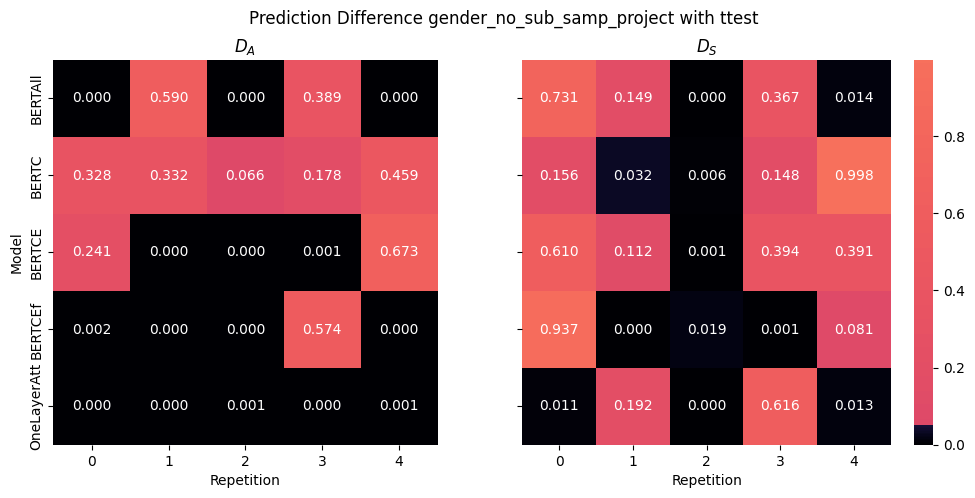

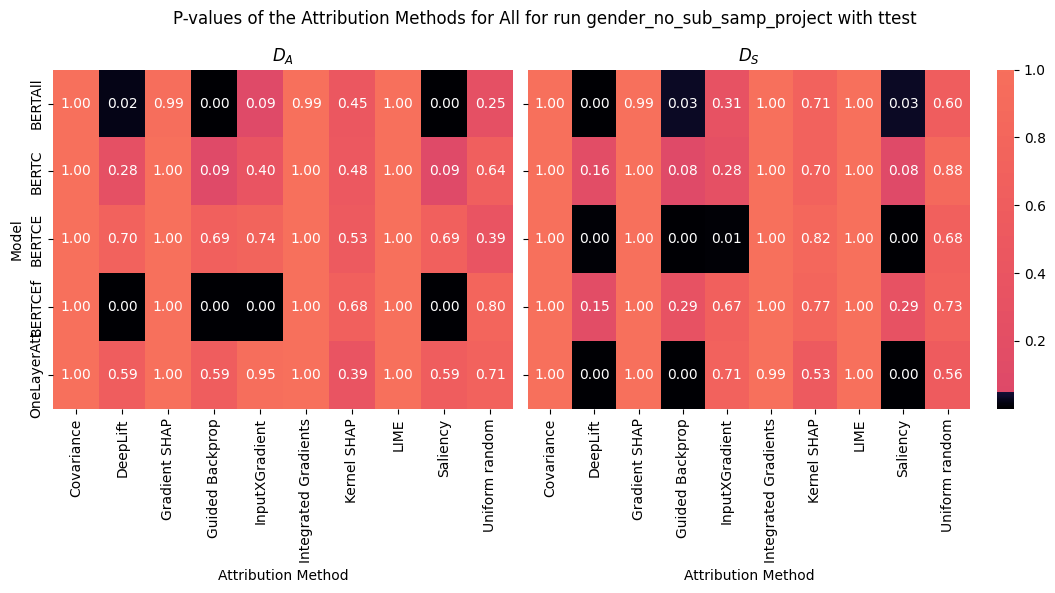

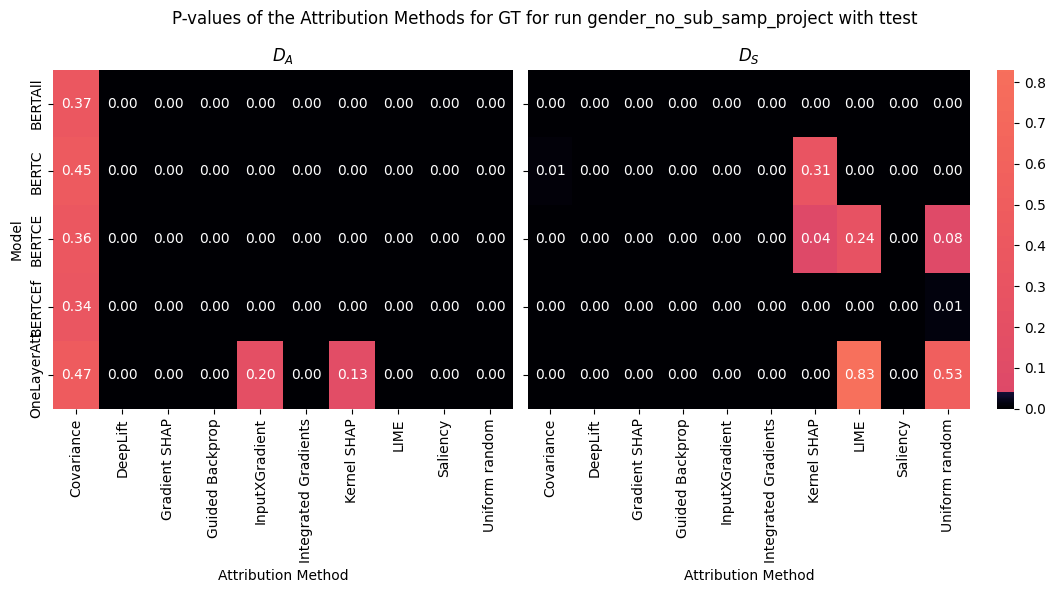

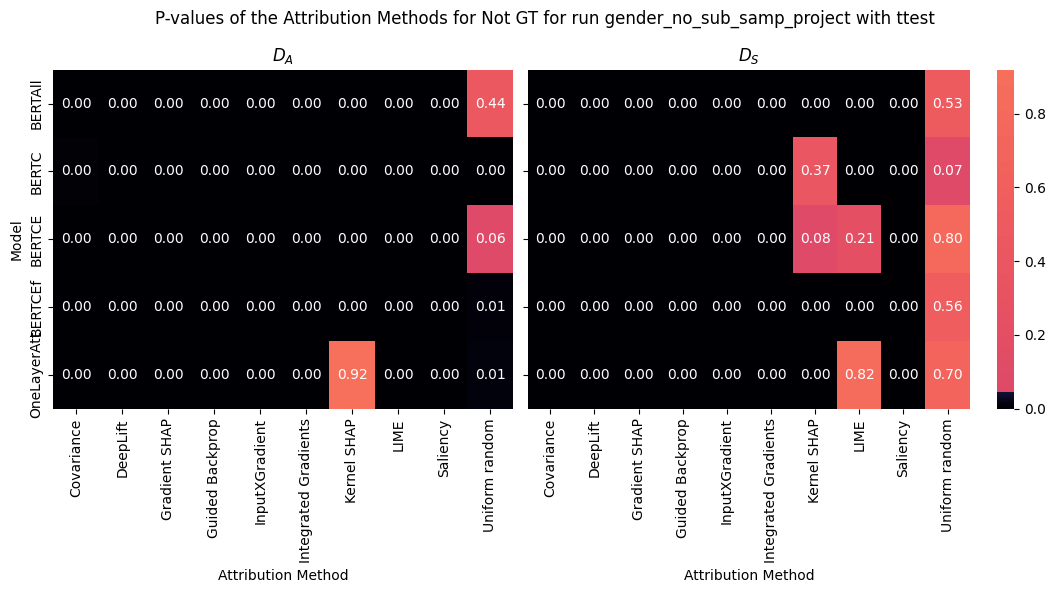

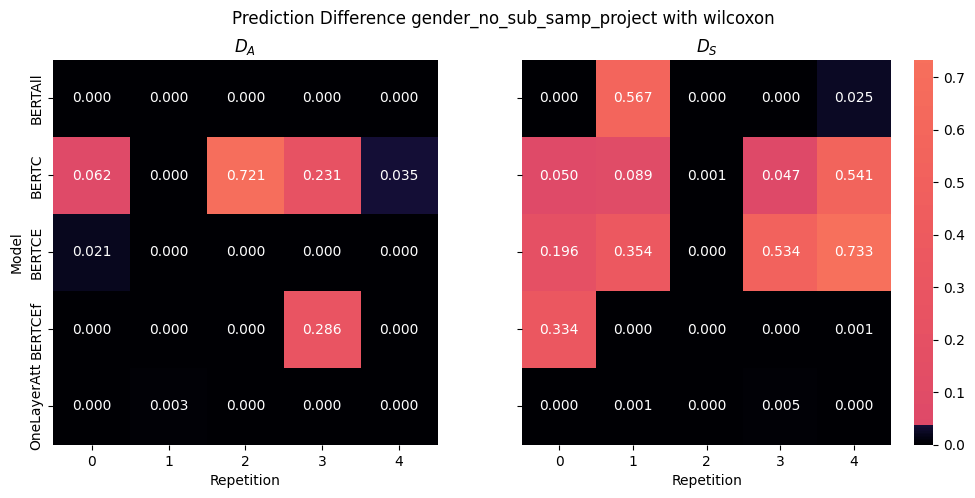

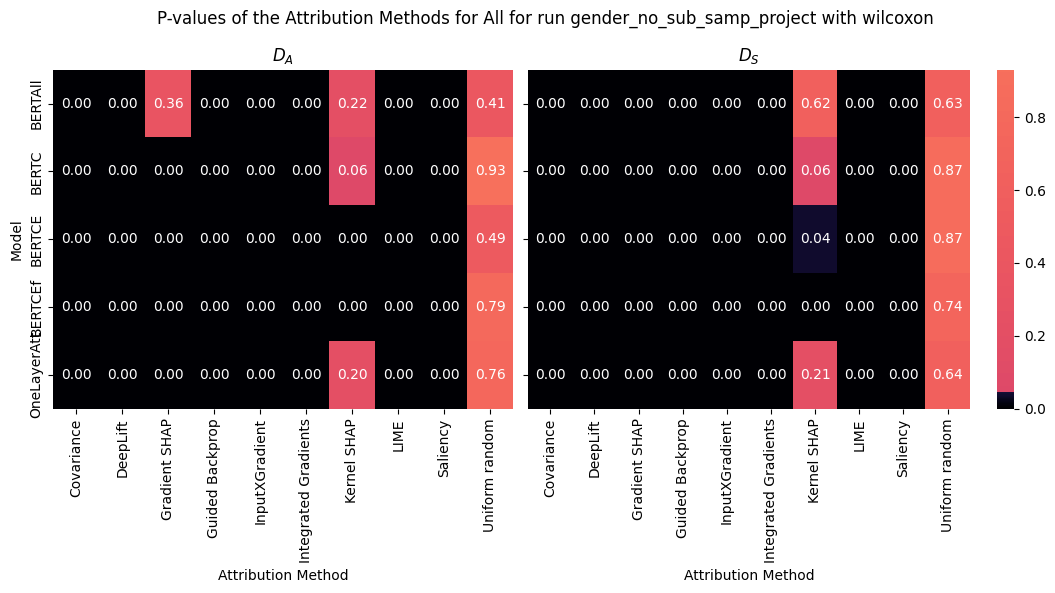

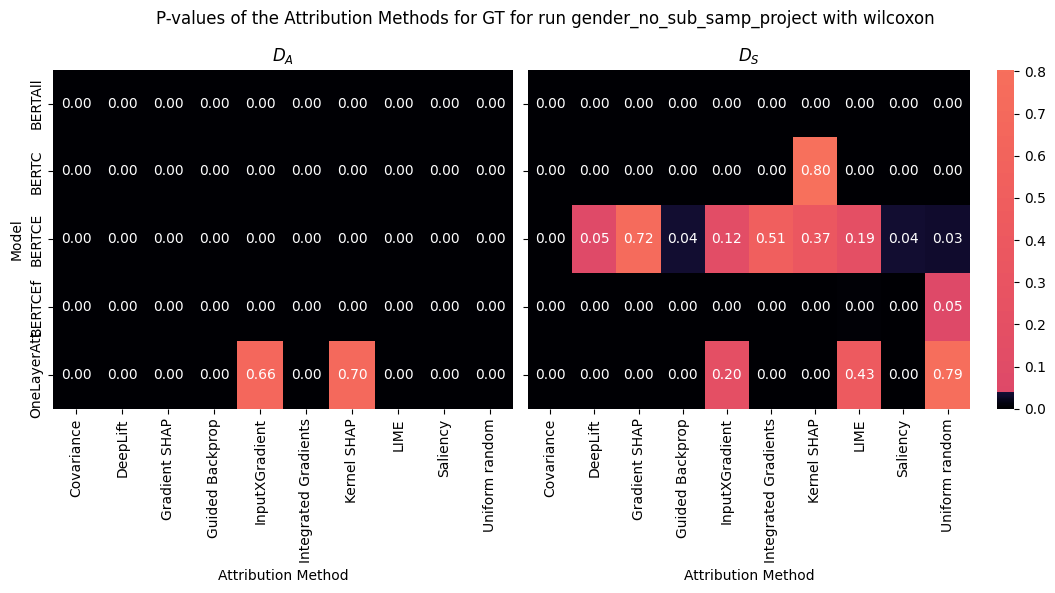

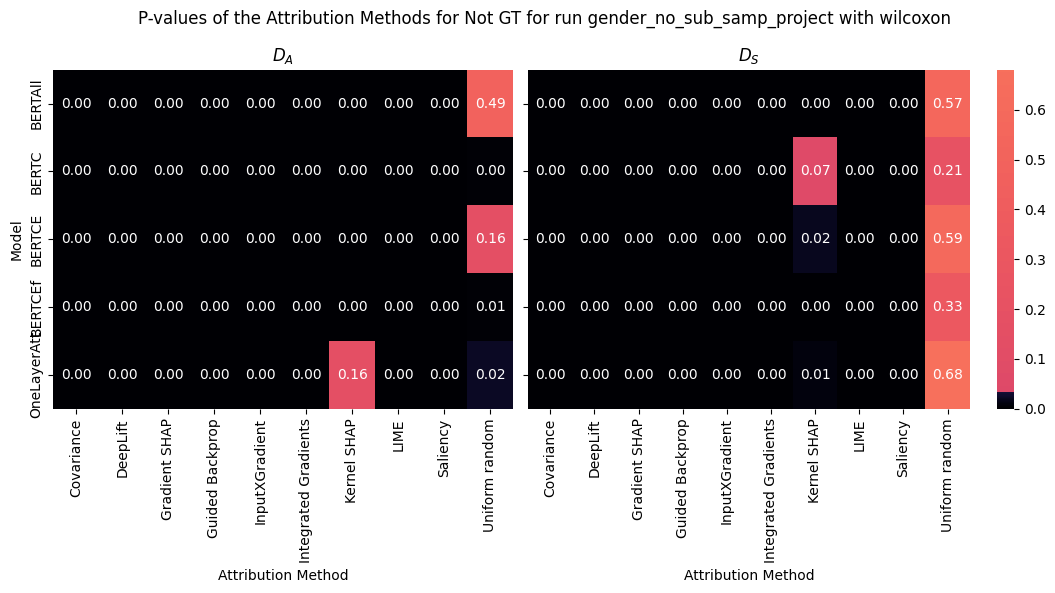

In [22]:
for _, key, idx in configs:
    test_and_plot(key)

In [23]:
with open(f"gender_no_sub_samp_project_config_diffs.pkl", "rb") as f:
    data = pickle.load(f)

    pred_diffs_df =  data["pred_diffs_df"]
    attribution_diffs_df = data["attribution_diffs_df"]
    attribution_diffs_gt_df = data["attribution_diffs_gt_df"]
    attribution_diffs_not_gt_df = data["attribution_diffs_not_gt_df"]

#### Dataset:  gender_all
Model: bert_all
-  Mean von Mean: -0.001 Std von Mean: 0.002
-  Mean von std: 0.009 Std von std: 0.006

Model: bert_only_classification
-  Mean von Mean: -0.003 Std von Mean: 0.004
-  Mean von std: 0.073 Std von std: 0.002

Model: bert_only_embedding_classification
-  Mean von Mean: 0.006 Std von Mean: 0.013
-  Mean von std: 0.05 Std von std: 0.01

Model: bert_randomly_init_embedding_classification
-  Mean von Mean: -0.009 Std von Mean: 0.016
-  Mean von std: 0.069 Std von std: 0.008

Model: one_layer_attention_classification
-  Mean von Mean: 0.006 Std von Mean: 0.008
-  Mean von std: 0.043 Std von std: 0.008

#### Dataset:  gender_subj
Model: bert_all
-  Mean von Mean: -0.001 Std von Mean: 0.007
-  Mean von std: 0.04 Std von std: 0.008

Model: bert_only_classification
-  Mean von Mean: 0.008 Std von Mean: 0.02
-  Mean von std: 0.192 Std von std: 0.003

Model: bert_only_embedding_classification
-  Mean von Mean: -0.021 Std von Mean: 0.018
-  Mean von std: 0.1

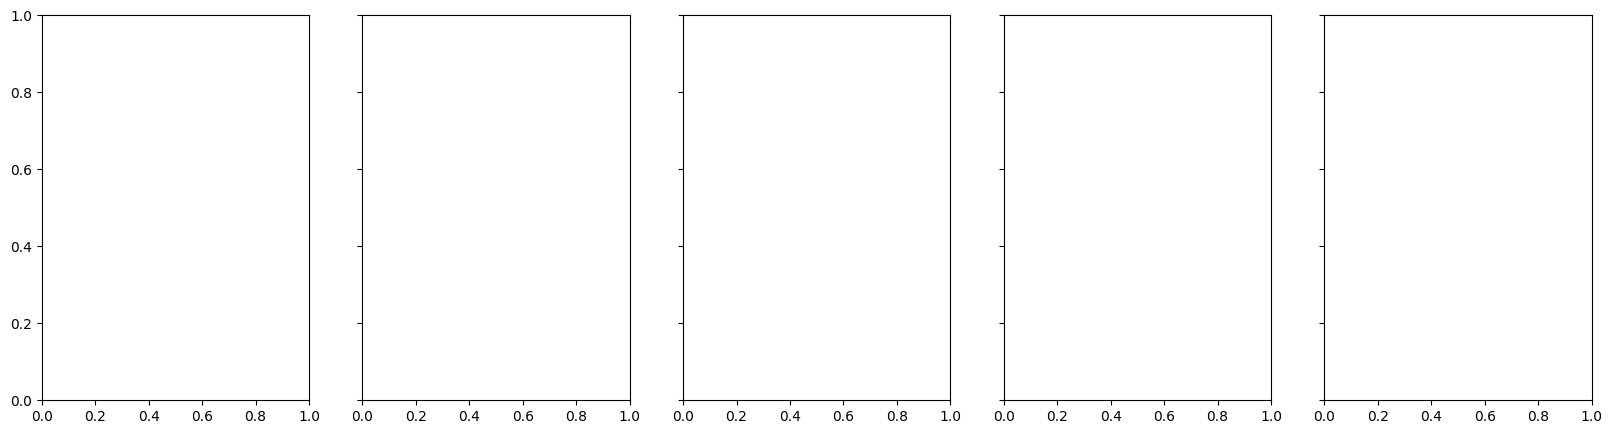

In [31]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

for dataset, group_ds in pred_diffs_df.groupby("dataset_type"):
    print("#### Dataset: ", dataset)
    for model, group in group_ds.groupby("model_name"):
        print(f"Model: {model}")

        stds = []
        means = []
        for model_repetition_number, group_rep in group.groupby("model_repetition_number"):
            means += [group_rep["pred_diff"].mean()]
            stds += [group_rep["pred_diff"].std()]
        
        print(f"-  Mean von Mean: {np.round(np.mean(means), 3)} Std von Mean: {np.round(np.std(means), 3)}")
        print(f"-  Mean von std: {np.round(np.mean(stds), 3)} Std von std: {np.round(np.std(stds), 3)}")
        print()



# for model_repetition_number, group in pred_diffs_df.groupby("model_repetition_number"):
#     print("Model Repetition Number: ", model_repetition_number)
#     print("Std: ", group["pred_diff"].std())
#     print("Mean: ", group["pred_diff"].mean())
#     sns.histplot(group["pred_diff"], ax=axs[model_repetition_number], bins=20)
#     axs[model_repetition_number].set_title(f"Repetition {model_repetition_number}")

In [28]:
0.02 / 0.006

3.3333333333333335

array([[<Axes: title={'center': 'attribution_diff'}>]], dtype=object)

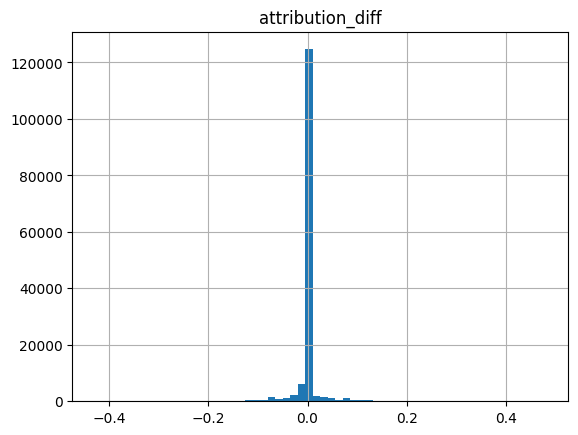

In [37]:
attribution_diffs_df[(attribution_diffs_df["attribution_method"] == "Covariance") & (attribution_diffs_df["dataset_type"] == "gender_all")].hist("attribution_diff", bins=60)

In [53]:
attribution_diffs_df["attribution_method"].unique()

array(['Covariance', 'DeepLift', 'Gradient SHAP', 'Guided Backprop',
       'InputXGradient', 'Integrated Gradients', 'Kernel SHAP', 'LIME',
       'Saliency', 'Uniform random'], dtype=object)

In [60]:
# cur = attribution_diffs_df[(attribution_diffs_df["attribution_method"] == "Uniform random") & (attribution_diffs_df["dataset_type"] == "gender_subj")]["attribution_diff"].values
cur = attribution_diffs_df[(attribution_diffs_df["attribution_method"] == "Covariance") & (attribution_diffs_df["dataset_type"] == "gender_subj")]

# print("cur mean: ", np.mean(cur))
# print("cur std: ", np.std(cur))

# w_stat, p_value = stats.ttest_1samp(cur, 0)
# w_stat, p_value

In [61]:
cur

,model_name,model_version,model_repetition_number,dataset_type,attribution_method,sentence_idx,female_word,male_word,attribution_diff
60140,bert_all,best,0,gender_subj,Covariance,0,she,he,2.631645e-04
60141,bert_all,best,0,gender_subj,Covariance,0,appears,appears,-6.187873e-07
60142,bert_all,best,0,gender_subj,Covariance,0,attracted,attracted,-2.517956e-07
60143,bert_all,best,0,gender_subj,Covariance,0,to,to,-1.330689e-05
60144,bert_all,best,0,gender_subj,Covariance,0,rose,rose,-1.869068e-04
...,...,...,...,...,...,...,...,...,...
2577203,one_layer_attention_classification,best,4,gender_subj,Covariance,315,becomes,becomes,-4.275521e-06
2577204,one_layer_attention_classification,best,4,gender_subj,Covariance,315,a,a,0.000000e+00
2577205,one_layer_attention_classification,best,4,gender_subj,Covariance,315,slave,slave,-9.048203e-06
2577206,one_layer_attention_classification,best,4,gender_subj,Covariance,315,trader,trader,-6.405454e-06


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00, 6.0000e+00,
        1.0000e+00, 2.0000e+00, 6.0000e+00, 8.0000e+00, 1.2000e+01,
        1.8000e+01, 1.7000e+01, 3.3000e+01, 4.8000e+01, 8.7000e+01,
        1.2700e+02, 2.2700e+02, 4.8500e+02, 8.9900e+02, 1.7450e+03,
        3.1620e+03, 5.6540e+03, 8.2570e+03, 1.0975e+04, 1.3418e+04,
        1.5813e+04, 1.4789e+04, 1.2496e+04, 9.5290e+03, 7.0230e+03,
        4.2730e+03, 2.3280e+03, 1.2140e+03, 6.5200e+02, 3.7200e+02,
        1.8900e+02, 1.2200e+02, 1.0400e+02, 4.3000e+01, 2.3000e+01,
        2.0000e+01, 1.9000e+01, 1.2000e+01, 7.0000e+00, 5.0000e+00,
        4.0000e+00, 4.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00]),
 array([-0.43980636, -0.42750478, -0.4152032 , -0.40290162, -0.39060004,
        -0.37829846, -0.36599688, -0.3536953 , -0.34139372, -0.32909214,
        -0.31679056, -0.30448898, -0

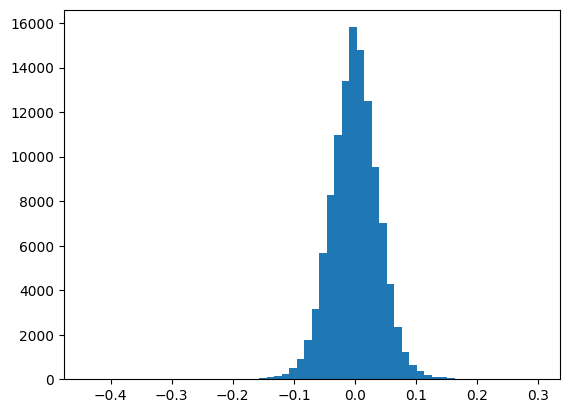

In [56]:
import matplotlib.pyplot as plt

# hist
plt.hist(cur, bins=60)

In [62]:
config = load_json_file("/home/hjall/work/qai/xai/xai-nlp-benchmark/artifacts/xai-nlp-benchmark-2024-04-23-21-20-02/configs/gender_no_sub_samp_project_config.json")
xai_results = load_xai_results(config)

Loading XAI results: 100%|██████████| 50/50 [00:56<00:00,  1.13s/it]


In [63]:
df = pd.DataFrame(xai_results)

In [72]:
for keys, group in df[df["attribution_method"] == "Covariance"].groupby(["model_name", "model_version", "model_repetition_number"]):
    print(keys)
    print(group[(group["sentence_idx"] == 0) & (group["target"] == 0) & (group["dataset_type"] == "gender_all")]["attribution"].iloc[0])
    print(group[(group["sentence_idx"] == 0) & (group["target"] == 1) & (group["dataset_type"] == "gender_all")]["attribution"].iloc[0])

('bert_all', 'best', 0)
[0.4739697456176278, 4.730325274073767e-05, 1.558606059223549e-05, 0.0011406239813988102, 0.010796867424064932, 3.117212118447098e-05, 0.0, 0.006748453923367004, 3.813905057346174e-05, 3.117212118447098e-05, 0.03304017916491151, 0.0, 0.0, 0.00010073261351615937, 3.910693002619227e-05, 0.4739697456176278, 1.558606059223549e-05, 1.558606059223549e-05, 0.0]
[0.46932388398413677, 4.700455143675116e-05, 1.548764079331743e-05, 0.0011334213927635323, 0.02011069650354852, 3.097528158663486e-05, 0.0, 0.006705840109939611, 3.7898217576172115e-05, 3.097528158663486e-05, 0.033070001258692666, 0.0, 0.0, 0.00010009652696253144, 3.885998525354088e-05, 0.46932388398413677, 1.548764079331743e-05, 1.548764079331743e-05, 0.0]
('bert_all', 'best', 1)
[0.4739697456176278, 4.730325274073767e-05, 1.558606059223549e-05, 0.0011406239813988102, 0.010796867424064932, 3.117212118447098e-05, 0.0, 0.006748453923367004, 3.813905057346174e-05, 3.117212118447098e-05, 0.03304017916491151, 0.0, 0